### creating the workspace and data
We being by creating a workspace for `deepql`, where we save models, data, etc...

In [1]:
import deepql
import matplotlib.pyplot as plt

# how to use the library
#deepql.help()

In [2]:
# this creates the folder structure used
# deepql.create_workspace()

# Type of Data
## data for `force_type="speed"`

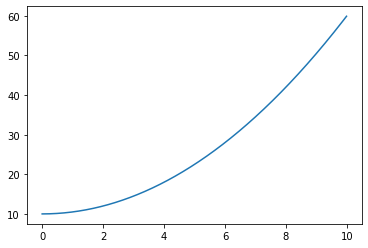

In [6]:
# define the functions for the differential equation to be solved numerically
N_steps = 1000
xi = 10
vi = 0
dt = 1e-2
relative_tolerance = 1e-1

def force_harmonic_oscillator(1):
    return 1

_, sol_status, data = deepql.integrate_diffeq(N=N_steps, xi=xi, vi=vi, 
    dt=dt, 
    force_function=force_harmonic_oscillator, force_type="speed",
    xtol=relative_tolerance)


plt.plot(data[:,0],data[:,1])
plt.show()

In [7]:
# saves the data
deepql.compile_data_to_csv(data, "harmonic_0506")

In [2]:
# now is timee to separate the data
# so its useful for our NN model
import pandas as pd
import deepql

df = pd.read_csv("./gen_data/harmonic_0506.csv")

df = deepql.separate_data(df, run_length=150, xmax=None, vmax=None)
df.head()

,x_initial,v_initial,x_step10,v_step10,x_step20,v_step20,x_step30,v_step30,x_step40,v_step40,...,x_step110,v_step110,x_step120,v_step120,x_step130,v_step130,x_step140,v_step140,x_step150,v_step150
0,10.000,0.0,10.005,0.1,10.020,0.2,10.045,0.3,10.080,0.4,...,10.605,1.1,10.720,1.2,10.845,1.3,10.980,1.4,11.125,1.5
1,10.005,0.1,10.020,0.2,10.045,0.3,10.080,0.4,10.125,0.5,...,10.720,1.2,10.845,1.3,10.980,1.4,11.125,1.5,11.280,1.6
2,10.020,0.2,10.045,0.3,10.080,0.4,10.125,0.5,10.180,0.6,...,10.845,1.3,10.980,1.4,11.125,1.5,11.280,1.6,11.445,1.7
3,10.045,0.3,10.080,0.4,10.125,0.5,10.180,0.6,10.245,0.7,...,10.980,1.4,11.125,1.5,11.280,1.6,11.445,1.7,11.620,1.8
4,10.080,0.4,10.125,0.5,10.180,0.6,10.245,0.7,10.320,0.8,...,11.125,1.5,11.280,1.6,11.445,1.7,11.620,1.8,11.805,1.9


## data for `force_type="position"`

In [7]:
deepql.diffnet.diffNet(
    depth=150, dt=1e-2,
    post_process=True, pp_mu=0, pp_epsilon=1e-2
)

TypeError: diffNet.__init__() missing 2 required positional arguments: 'lower_limit' and 'upper_limit'

# Data Orbits

In [1]:
# so its useful for our NN model
import pandas as pd
import deepql

In [5]:
# cleaing the data of mercury:
datos = pd.read_csv('./gen_data/heun_E1L1.csv', index_col=0)
datos.head()

,t,r,velocity,theta,tau
0,5.194845,9.986768,-0.528598,0.00,4.986776
1,10.349559,9.947294,-1.047702,0.05,9.934209
2,15.438519,9.882283,-1.548236,0.10,14.817185
3,20.437738,9.792876,-2.021929,0.15,19.612206
4,25.325393,9.680598,-2.461641,0.20,24.297905


In [7]:
# mirando las diferencias de theta saacmos el dt
dt = 0.05

In [6]:
datos_clean = deepql.separate_data(datos, position='r')
datos_clean.head()

,x_initial,v_initial,x_step10,v_step10,x_step20,v_step20,x_step30,v_step30,x_step40,v_step40,x_step50,v_step50
0,9.986768,-0.528598,8.643641,-4.167684,6.495147,-3.988987,4.828447,-2.668776,3.774754,-1.613572,3.152756,-0.923605
1,8.643641,-4.167684,6.495147,-3.988987,4.828447,-2.668776,3.774754,-1.613572,3.152756,-0.923605,2.813170,-0.461294
2,6.495147,-3.988987,4.828447,-2.668776,3.774754,-1.613572,3.152756,-0.923605,2.813170,-0.461294,2.673123,-0.109420
3,4.828447,-2.668776,3.774754,-1.613572,3.152756,-0.923605,2.813170,-0.461294,2.673123,-0.109420,2.699520,0.216983
4,3.774754,-1.613572,3.152756,-0.923605,2.813170,-0.461294,2.673123,-0.109420,2.699520,0.216983,2.898528,0.594204


In [8]:
datos_clean.to_csv("./data/heunE1L1.csv")

## Training the model

In [1]:
# modulos dentro de deepql
import deepql

import torch
import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# informacion para training:
name = "heunE1L1"
csv_file = "./data/heunE1L1.csv"
dt = 0.05

In [3]:
my_dataset = deepql.MyDataset(pd.read_csv(csv_file, index_col=0), step_size=50)
my_dataloader = deepql.DataLoader(my_dataset, batch_size=32, shuffle=True)

In [4]:
# Loading the model
model_name = "0523"

#model = torch.load(f"./model/{model_name}.pt")
# plt.plot(list(model.parameters())[0].detach())
# plt.title("Loaded parameters of activation function")
# plt.show()

In [5]:
from diffnet import diffNet, smooth_loss, physics_constrain

model = diffNet(depth=50, lower_limit=0, upper_limit=15, dt=dt)

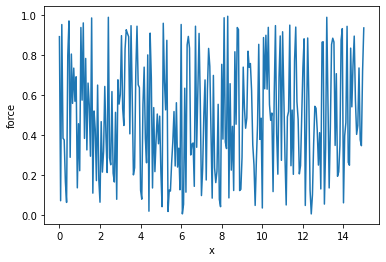

In [6]:
model.plot_parameters()

In [7]:
for i, data in enumerate(my_dataloader, 0):
    # Get inputs and targets from data
    inputs, targets = data

In [8]:
# Hyperparameters
smooth_rate = 0.03
constrain_rate = 0 # F(v=0) = 0
targets_rate = 1.25

# Define number of epochs
num_epochs = 500

# Define loss function and optimizer
L2_loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

running_loss = 0
loss_array = []

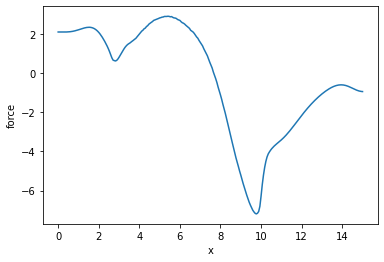

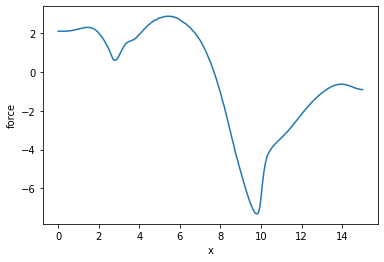

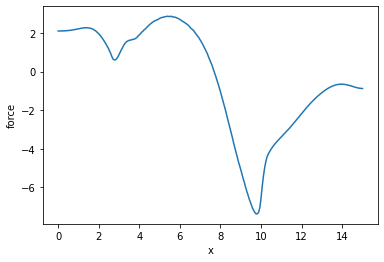

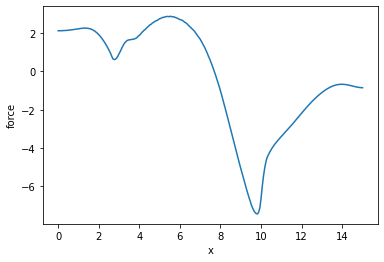

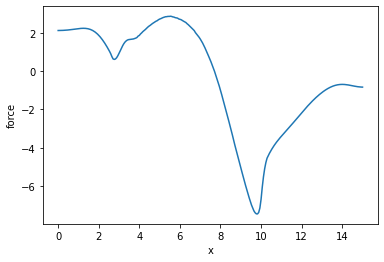

Finished training


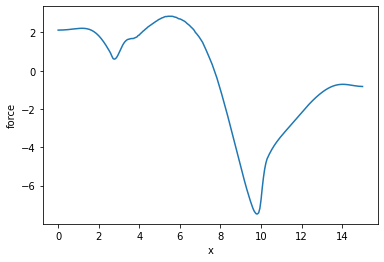

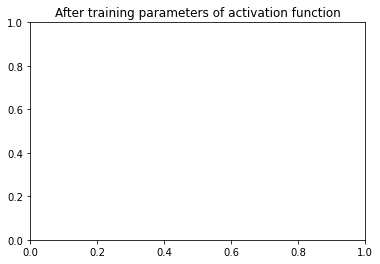

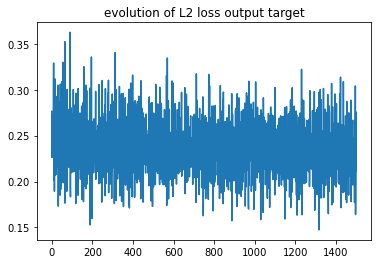

In [13]:
#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        L2_computed_loss = L2_loss(outputs, targets)
        # Compute loss
        loss = smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_computed_loss

        loss_array.append(loss.item())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_computed_loss.detach().item())
            #loss_array.append(L2_computed_loss.detach().item())
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 100 == 10:
        # saving the model
        torch.save(model, f"./model/{name}_epoch{epoch}.pt")
        
        #ploting
        model.plot_parameters()
        # plt.show()
        # plt.savefig(f"./evolution_force/{name}_epoch_{epoch}_loss_{running_loss :.2f}.png")


# finish training
torch.save(model, f"./model/{name}_epoch{epoch}.pt")
print('Finished training')

model.plot_parameters()
plt.title("After training parameters of activation function")
plt.show()

# plot loss
plt.plot(loss_array)
plt.title("evolution of L2 loss output target")
plt.show()